In [112]:
import os

import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append("../scripts")

import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy

import matplotlib.pyplot as plt

plt.style.use("../papers/intro_paper/MATPLOTLIB_RCPARAMS.sty") 
import corner

In [113]:
# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR



def eff_quant_parspec(m1, m2, a1z, a2z, domega220, dtau220):

    f_220 = np.zeros(len(m1))
    tau_220 = np.zeros(len(m1))
    
    
    for idx in range(len(m1)):
    
        i, finalMass, finalSpin = lalsim.SimIMREOBFinalMassSpin(m1[idx], m2[idx], \
                                                             np.array([0., 0., a1z[idx]]), np.array([0., 0., a2z[idx]]), \
                                                             lalsim.SEOBNRv4)
        
        
        omegaNGR = 0.3737 * (1. + domega220[idx]);
        omegaGR = 0.1258*finalSpin + 0.0717*pow(finalSpin,2) + 0.0480*pow(finalSpin,3) + 0.0350*pow(finalSpin,4);

        tauNGR = 11.2407 * (1. + dtau220[idx]);
        tauGR = 0.2522*finalSpin + 0.6649*pow(finalSpin,2) + 0.5866*pow(finalSpin,3) + 0.5797*pow(finalSpin,4);
        
        omega_220 = 1./finalMass/(m1[idx]+m2[idx])/lal.MTSUN_SI*(omegaNGR + omegaGR)
        f_220[idx] = omega_220/(2.*np.pi)
        
        tau_220[idx] = finalMass * (m1[idx]+m2[idx]) * lal.MTSUN_SI * (tauGR + tauNGR)
        
    return f_220, tau_220

In [114]:
parspec_1d = "../runs/O1O2/GW150914/220_deyan_PA_parspec_noalpha_D0_p0/cbcBayes/posterior_samples.dat"
parspec_2d = "../runs/O1O2/GW150914/220_deyan_PA_parspec_noalpha_D0_p0_dfdtau/cbcBayes/posterior_samples.dat"

pSEOB_2d = "../runs/O1O2/GW150914/220/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat"

In [121]:
data_parspec_2d = np.genfromtxt(parspec_2d, names=True, dtype=None)

m1, m2, a1z, a2z, domega220, dtau220 =  data_parspec_2d["m1"], data_parspec_2d["m2"], \
                                        data_parspec_2d["a1z"], data_parspec_2d["a2z"], \
                                        data_parspec_2d["domega220"], data_parspec_2d["dtau220"]

f_ps, tau_ps = eff_quant_parspec(m1, m2, a1z, a2z, domega220, dtau220 )
tau_ps *= 1000.

f_pseob, tau_pseob = np.genfromtxt(pSEOB_2d, unpack=True)
tau_pseob *= 1000.

<Figure size 864x864 with 0 Axes>

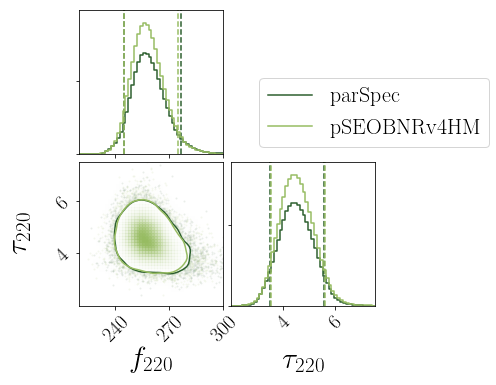

In [148]:
color1 = '#2C5F2D'
color2 = '#97BC62FF'

plt.figure(figsize=(12,12))

fig = corner.corner(np.vstack([f_ps, tau_ps]).T, bins=50, color=color1, smooth=1.5, smooth1d=1.5, weights=None, hist_bin_factor=1, 
              range=[[220,300],[2,7.5]],
              labels=['$f _{220}$','$\\tau _{220}$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=None, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=False )

corner.corner(np.vstack([f_pseob, tau_pseob]).T, bins=50, color=color2, smooth=1.5, smooth1d=1.5, weights=None, hist_bin_factor=1, 
              range=[[220,300],[2,7.5]],
              labels=['$f _{220}$','$\\tau _{220}$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=fig, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=False )

plt.plot(0,0,color=color1,label='parSpec')
plt.plot(0,0,color=color2,label='pSEOBNRv4HM')
plt.legend(loc=[0.2,1.1], fontsize=22)
plt.show()
